<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S14/Dataset_Creation-DenseDepth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cuda Device Properties**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from IPython.display import Image, clear_output 

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.1+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [ ]:
%tensorflow_version 1.x
%matplotlib inline

TensorFlow 1.x selected.


**Clone the GitHub Repo**

In [ ]:
!git clone https://github.com/Gilf641/DenseDepth

Cloning into 'DenseDepth'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 298 (delta 32), reused 31 (delta 11), pack-reused 236
Receiving objects: 100% (298/298), 11.84 MiB | 31.32 MiB/s, done.
Resolving deltas: 100% (148/148), done.


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
# Upload few images to test folder
import os
os.chdir("/content/DenseDepth")
!ls
!mkdir test/

augment.py	demo.py		  examples   model.py	Tensorflow
callbacks.py	demo_rgb.npy	  layers.py  PyTorch	test.py
data.py		DenseDepth.ipynb  LICENSE    README.md	train.py
demo_depth.npy	evaluate.py	  loss.py    samples	utils.py


**Download the Weights**

In [ ]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O ./nyu.h5

--2020-07-19 09:26:31--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.90.83
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.90.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘./nyu.h5’

./nyu.h5            100%[===================>] 164.89M  26.8MB/s    in 6.9s    

2020-07-19 09:26:38 (24.0 MB/s) - ‘./nyu.h5’ saved [172897376/172897376]



**Mount the Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:


!cd /content/drive/My\ Drive/S15\ Dataset

/bin/bash: line 0: cd: /content/drive/My Drive/S15 Dataset: No such file or directory


**Modified UTILS File**

In [ ]:
import numpy as np
from PIL import Image
from skimage.transform import resize
def DepthNorm(x, maxDepth):
    return maxDepth / x

def predict(model, images, minDepth=10, maxDepth=1000, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale 
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return np.clip(DepthNorm(predictions, maxDepth=maxDepth), minDepth, maxDepth) / maxDepth

def scale_up(scale, images):
    from skimage.transform import resize
    scaled = []
    
    for i in range(len(images)):
        img = images[i]
        output_shape = (scale * img.shape[0], scale * img.shape[1])
        scaled.append(resize(img, output_shape, order=1, preserve_range=True, mode='reflect', anti_aliasing=True ) )

    return np.stack(scaled)

def load_images(image_files):
    loaded_images = []
    for file in image_files:
      try:
        x = np.clip(np.asarray(Image.open( file ), dtype=float) / 255, 0, 1) # clip and conv it into np array
        x = resize(x, (448,448,3)) # resize it 448,448
        loaded_images.append(x)
      except Exception as e:
        print("Skipped this image due to", e)
    return np.stack(loaded_images, axis=0)

def to_multichannel(i):
    if i.shape[2] == 3: return i
    i = i[:,:,0]
    return np.stack((i,i,i), axis=2)
        
def display_images(outputs, inputs=None, gt=None, is_colormap=True, is_rescale=True):
    import matplotlib.pyplot as plt
    import skimage
    from skimage.transform import resize

    plasma = plt.get_cmap('plasma')

    shape = (outputs[0].shape[0], outputs[0].shape[1], 3)
    
    all_images = []

    for i in range(outputs.shape[0]):
        imgs = []
        
        if isinstance(inputs, (list, tuple, np.ndarray)):
            x = to_multichannel(inputs[i])
            x = resize(x, shape, preserve_range=True, mode='reflect', anti_aliasing=True )
            imgs.append(x)

        if isinstance(gt, (list, tuple, np.ndarray)):
            x = to_multichannel(gt[i])
            x = resize(x, shape, preserve_range=True, mode='reflect', anti_aliasing=True )
            imgs.append(x)

        if is_colormap:
            rescaled = outputs[i][:,:,0]
            if is_rescale:
                rescaled = rescaled - np.min(rescaled)
                rescaled = rescaled / np.max(rescaled)
            imgs.append(plasma(rescaled)[:,:,:3])
        else:
            imgs.append(to_multichannel(outputs[i]))

        img_set = np.hstack(imgs)
        all_images.append(img_set)

    all_images = np.stack(all_images)
    
    return skimage.util.montage(all_images, multichannel=True, fill=(0,0,0))

def save_images(filename, outputs, inputs=None, gt=None, is_colormap=True, is_rescale=False):
    montage =  display_images(outputs, inputs, is_colormap, is_rescale)
    im = Image.fromarray(np.uint8(montage*255))
    im.save(filename)

def load_test_data(test_data_zip_file='nyu_test.zip'):
    print('Loading test data...', end='')
    import numpy as np
    from data import extract_zip
    data = extract_zip(test_data_zip_file)
    from io import BytesIO
    rgb = np.load(BytesIO(data['eigen_test_rgb.npy']))
    depth = np.load(BytesIO(data['eigen_test_depth.npy']))
    crop = np.load(BytesIO(data['eigen_test_crop.npy']))
    print('Test data loaded.\n')
    return {'rgb':rgb, 'depth':depth, 'crop':crop}

def compute_errors(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25   ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()
    abs_rel = np.mean(np.abs(gt - pred) / gt)
    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())
    log_10 = (np.abs(np.log10(gt)-np.log10(pred))).mean()
    return a1, a2, a3, abs_rel, rmse, log_10

def evaluate(model, rgb, depth, crop, batch_size=6, verbose=False):
    N = len(rgb)

    bs = batch_size

    predictions = []
    testSetDepths = []
    
    for i in range(N//bs):    
        x = rgb[(i)*bs:(i+1)*bs,:,:,:]
        
        # Compute results
        true_y = depth[(i)*bs:(i+1)*bs,:,:]
        pred_y = scale_up(2, predict(model, x/255, minDepth=10, maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0
        
        # Test time augmentation: mirror image estimate
        pred_y_flip = scale_up(2, predict(model, x[...,::-1,:]/255, minDepth=10, maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0

        # Crop based on Eigen et al. crop
        true_y = true_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y = pred_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y_flip = pred_y_flip[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        
        # Compute errors per image in batch
        for j in range(len(true_y)):
            predictions.append(   (0.5 * pred_y[j]) + (0.5 * np.fliplr(pred_y_flip[j]))   )
            testSetDepths.append(   true_y[j]   )

    predictions = np.stack(predictions, axis=0)
    testSetDepths = np.stack(testSetDepths, axis=0)

    e = compute_errors(predictions, testSetDepths)

    if verbose:
        print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))
        print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(e[0],e[1],e[2],e[3],e[4],e[5]))

    return e


In [ ]:
# !apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
os.chdir("/content/drive/My Drive/FG_BG/images")
os.getcwd()

'/content/drive/My Drive/FG_BG/images'

In [ ]:
# !7za e /content/drive/My\ Drive/FG_BG/zip_folder/b12-13-14.zip

In [ ]:
# len(os.listdir("/content/drive/My Drive/FG_BG/images"))

1203

In [ ]:
# os.listdir("/content/drive/My Drive/FG_BG/batches")

In [ ]:
# # Unzip the files
# import zipfile
# path_to_zip_file = "/content/drive/My\ Drive/FG_BG/Zip-20.zip"
# directory_to_extract_to = "/content/drive/My Drive/FG_BG"

# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

**Modified Layers File**

In [ ]:
from keras.engine.topology import Layer, InputSpec
import keras.utils.conv_utils as conv_utils
import tensorflow as tf
import keras.backend as K

class BilinearUpSampling2D(Layer):
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(BilinearUpSampling2D, self).__init__(**kwargs)
        self.data_format = K.normalize_data_format(data_format)
        self.size = conv_utils.normalize_tuple(size, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
            return (input_shape[0],
                    input_shape[1],
                    height,
                    width)
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
            return (input_shape[0],
                    height,
                    width,
                    input_shape[3])

    def call(self, inputs):
        input_shape = K.shape(inputs)
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
        
        return tf.image.resize_images(inputs, [height, width], method=tf.image.ResizeMethod.BILINEAR, align_corners=True)

    def get_config(self):
        config = {'size': self.size, 'data_format': self.data_format}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + 
list(config.items()))

 


Using TensorFlow backend.


In [ ]:
import os
os.chdir("/content/drive/My Drive/ZipFile_909-1000")
!unzip '/content/drive/My Drive/ZipFile_909-1000/batch1000.zip'

Archive:  /content/drive/My Drive/ZipFile_909-1000/batch1000.zip
replace batch0909/bg_091_fg_161_001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


#Try this code. Debug it and run it for seperate batches. If it works else continue with 2 batch thing generating 800 images

**Here you can loop around folders create depth maps seperately for each of them and then ...**

In [ ]:
import os
len(os.listdir("/content/drive/My Drive/ZipExtract/Depth Maps/batch0475"))

**Load the model**

In [ ]:

from keras.models import load_model
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

# Load model into GPU / CPU
model_path = "/content/DenseDepth/nyu.h5"
model = load_model(model_path, custom_objects=custom_objects, compile=False)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [ ]:
import time
from PIL import Image
import os 
 
batch_path = "/content/drive/My Drive/ZipFile_909-1000"
len(os.listdir(batch_path))
# image_files = []



93

In [ ]:
# from google.colab import drive
# drive.flush_and_unmount()   

In [ ]:
os.mkdir("/content/drive/My Drive/DepthMaps6") # for 909-1000

FileExistsError: ignored

In [ ]:
os.listdir("/content/drive/My Drive/ZipFile_909-1000")[1:]

['batch0909',
 'batch0910',
 'batch0911',
 'batch0912',
 'batch0913',
 'batch0914',
 'batch0915',
 'batch0916',
 'batch0917',
 'batch0918',
 'batch0919',
 'batch0920',
 'batch0921',
 'batch0922',
 'batch0923',
 'batch0924',
 'batch0925',
 'batch0926',
 'batch0927',
 'batch0928',
 'batch0929',
 'batch0930',
 'batch0931',
 'batch0932',
 'batch0933',
 'batch0934',
 'batch0935',
 'batch0936',
 'batch0937',
 'batch0938',
 'batch0939',
 'batch0940',
 'batch0941',
 'batch0942',
 'batch0943',
 'batch0944',
 'batch0945',
 'batch0946',
 'batch0947',
 'batch0948',
 'batch0949',
 'batch0950',
 'batch0951',
 'batch0952',
 'batch0953',
 'batch0954',
 'batch0955',
 'batch0956',
 'batch0957',
 'batch0958',
 'batch0959',
 'batch0960',
 'batch0961',
 'batch0962',
 'batch0963',
 'batch0964',
 'batch0965',
 'batch0966',
 'batch0967',
 'batch0968',
 'batch0969',
 'batch0970',
 'batch0971',
 'batch0972',
 'batch0973',
 'batch0974',
 'batch0975',
 'batch0976',
 'batch0977',
 'batch0978',
 'batch0979',
 'batc

In [ ]:
len(os.listdir("/content/drive/My Drive/DepthMaps5/batch0912"))

400

In [ ]:

overall_time = time.time()
for i in os.listdir(batch_path)[1:]:
  # if not i.endswith(".zip"):
    print("batch_name", i)
    start_time = time.time()
    files = os.listdir(os.path.join(batch_path, i))
    image_files = [os.path.join(os.path.join(batch_path, i), f) for f in files]
    batch_name = i.split("/")[-1]
    print("No of Image files", len(image_files))



    # Input images
    inputs = load_images(image_files)
    load_time = time.time()
    print('\nLoaded ({0}) images of size {1}'.format(inputs.shape[0], inputs.shape[1:]))#, time.time-load_time))

    # Compute results
    outputs = predict(model, inputs)
    output_time = time.time()
    print('\nLoaded ({0}) files.'.format(len(outputs)))#, time.time-output_time))

    del inputs
    print("Inputs deleted...")

    save_main_path = "/content/drive/My Drive/DepthMaps6"# this is the path where you want to save all the depth images


    #create a sub directory
    os.chdir(save_main_path)
    if not os.path.exists(os.path.join(save_main_path, batch_name)):#or not os.listdir(os.path.join(save_main_path, batch_name)):
      os.mkdir(os.path.join(save_main_path, batch_name))
      folder_path = os.path.join(save_main_path, batch_name)
    
    # else:
    #   folder_path = os.path.join(save_main_path, batch_name)
    
    # remove all the files in that directory
    # for f in os.listdir(os.path.join(batch_path, i)):
    #   os.remove(os.path.join(os.path.join(batch_path, i), f))

    for i in range(len(outputs)):
      # print("entered for loop")
      im = Image.fromarray((outputs[i][:,:,0]* 255).astype(np.uint8))
      # print(im)
      first_name =  image_files[i].split(".")[0]
      name = first_name.split("/")[-1]+ "_depth_map_"+str(i+1).zfill(3)+".jpeg"
      print(name)
      im.save(os.path.join(folder_path, name), format="jpeg")
      print("Image Saved...")

    # what I could have done, save all these depth maps in a folder and zip it then download the same...
    
    print(f"--- {(time.time() - start_time)} Total seconds for: {batch_name} ---")

Streaming output truncated to the last 5000 lines.
bg_100_fg_077_006_depth_map_326.jpeg
Image Saved...
bg_100_fg_077_007_depth_map_327.jpeg
Image Saved...
bg_100_fg_077_008_depth_map_328.jpeg
Image Saved...
bg_100_fg_077_009_depth_map_329.jpeg
Image Saved...
bg_100_fg_077_010_depth_map_330.jpeg
Image Saved...
bg_100_fg_077_011_depth_map_331.jpeg
Image Saved...
bg_100_fg_077_012_depth_map_332.jpeg
Image Saved...
bg_100_fg_077_013_depth_map_333.jpeg
Image Saved...
bg_100_fg_077_014_depth_map_334.jpeg
Image Saved...
bg_100_fg_077_015_depth_map_335.jpeg
Image Saved...
bg_100_fg_077_016_depth_map_336.jpeg
Image Saved...
bg_100_fg_077_017_depth_map_337.jpeg
Image Saved...
bg_100_fg_077_018_depth_map_338.jpeg
Image Saved...
bg_100_fg_077_019_depth_map_339.jpeg
Image Saved...
bg_100_fg_077_020_depth_map_340.jpeg
Image Saved...
bg_100_fg_078_001_depth_map_341.jpeg
Image Saved...
bg_100_fg_078_002_depth_map_342.jpeg
Image Saved...
bg_100_fg_078_003_depth_map_343.jpeg
Image Saved...
bg_100_fg_078

**Zip the File and Download the same**

In [ ]:
import shutil 
path = "/content/drive/My Drive/DepthMaps6"
shutil.make_archive("depth_images_909-1000","zip",path)

'/content/drive/My Drive/DepthMaps6/depth_images_909-1000.zip'

In [ ]:
from google.colab import files
files.download( "/content/drive/My Drive/DepthMaps6/depth_images_909-1000.zip" ) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# folderpath = '/content/drive/My Drive/DepthMaps2'
# folders = os.listdir(folderpath)
# # folders
# for folder in folders[:1]:
#   for file in os.listdir(os.path.join(folderpath, folder)):
#     print("Image downloaded", file)
#     files.download(os.path.join(os.path.join(folderpath, folder), file)) 
# files.download(  )

In [ ]:
import shutil
# os.mkdir('/content/drive/My Drive/CopyDepthMaps-2')
original = '/content/drive/My Drive/DepthMaps2'
target = '/content/drive/My Drive/CopyDepthMaps-2'

original_files = os.listdir(original)
for f in original_files:
  for im in os.listdir(f):
    try:
      shutil.copyfile(os.path.join(os.path.join(original,f),im), os.path.join(target,im))
    except Exception as e:
      print('{0} excepted due to {1}'.format(im,e))

KeyboardInterrupt: ignored

In [ ]:
# /content/drive/My Drive/ZipExtract/Depth Maps

**This you can use by zipping two folders and generating 800 Depth Images**

In [ ]:
# os.chdir("/content/drive/My Drive/FG_BG/tempimg/b12-13-14")
p = "/content/drive/My Drive/FG_BG/tempimg/batch0047"
q = "/content/drive/My Drive/FG_BG/tempimg/batch0048"


p_image = [os.path.join(p,i) for i in os.listdir(p)]
q_image = [os.path.join(q,i) for i in os.listdir(q)]

r_image = p_image+q_image

from keras.models import load_model
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

# Load model into GPU / CPU
model_path = "/content/DenseDepth/nyu.h5"
model = load_model(model_path, custom_objects=custom_objects, compile=False)


# Input images
inputs = load_images(r_image)
print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))

# Compute results
outputs = predict(model, inputs)
print(len(outputs))
%time

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Loaded (800) images of size (448, 448, 3).

800
CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 5.48 µs


**ZipFile Method**

In [ ]:
# from zipfile import ZipFile
# import shutil 
# import os

# temp_path = "/content/drive/My Drive/FG_BG/tempimg"

# bg_fg =  ZipFile('/content/drive/My Drive/FG_BG/zip copy/Copy of b12-13-14.zip', 'r')
# bg_fg.infolist()

# files = [info.filename for info in bg_fg.infolist()]# if info.filename[8] == 'f']
# files

# for f in files:
#   shutil.move(f, os.path.join(temp_path))

# # # inputs = load_images(files)
# # # print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))

# # # # Compute results
# # # outputs = predict(model, inputs)
# # # print(len(outputs))

# # # import timeit
# # # from PIL import Image
# # # %timeit
# # # save_path = "/content/drive/My Drive/FG_BG/zip copy/depth images" # this is the path where you want to save all the depth images
# # # for i in range(len(outputs)):
# # #   # print("entered for loop")
# # #   im = Image.fromarray((outputs[i][:,:,0]* 255).astype(np.uint8))
# # #   # print(im)
# # #   first_name =  image_list[i].split(".")[0]
# # #   name = first_name.split("/")[-1]+ "_depth_map_"+str(i+1).zfill(3)
# # #   print(name)
# # #   im.save(os.path.join(save_path, name), format="jpeg")
# # #   print("Image Saved...")

# # # with ZipFile('/content/drive/My Drive/FG_BG/zip_folder/b12-13-14.zip', 'a') as depth_zip:
# # #     for j,filename in enumerate(files[l:l+1000]):
# # #       re = outputs2[j][:,:,0]
# # #       re = re - np.min(re)
# # #       re = re / np.max(re)
# # #       cmap = plt.get_cmap('inferno')
# # #       re = cmap(re)[:,:,0]
# # #       img = Image.fromarray((re*255).astype(np.uint8))
# # #       img = img.resize((192,192))
# # #       img.save('test.jpg')

**Modified TEST File**

In [ ]:
len(os.listdir("/content/drive/My Drive/FG_BG/batches/batch0028"))

400

In [ ]:
# import os
# import glob
# import argparse
# import matplotlib

# # Keras / TensorFlow
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
# from keras.models import load_model
# # from layers import BilinearUpSampling2D
# # from utils import predict, load_images, display_images
# from matplotlib import pyplot as plt

# # Custom object needed for inference and training
# custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

# print('Loading model...')

# def convimage_to_array(imagepath="/content/drive/My Drive/FG_BG"):
#   img_array = []
#   for i in os.listdir(imagepath):
#     img = Image.open(os.path.join(path,i))
#     if i==0:
#       image = np.expand_dims(np.array(img, dtype=float)/255, axis=0)
#     else:
#       image = np.expand_dims(np.array(img, dtype=float)/255, axis=0)
#       img_array.append(image)
#   return img_array


# # Load model into GPU / CPU
# model_path = "/content/DenseDepth/nyu.h5"
# model = load_model(model_path, custom_objects=custom_objects, compile=False)

# print('\nModel loaded ({0}).'.format(model))

# path = "/content/drive/My Drive/FG_BG/batches/batch0028" # this is the path where you have all the fg_bg images
# image_list = [os.path.join(path,i) for i in os.listdir(path) if i.endswith(".jpeg")]
# print(image_list)

# # Input images
# inputs = load_images(image_list)
# print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))

# # Compute results
# outputs = predict(model, inputs)
# print(len(outputs))
# %time

In [ ]:

# import cv2
# from google.colab.patches import cv2_imshow

# i1 = outputs[1]
# np_i1 = np.array(i1)
# type(np_i1)
# np_i1.shape
# # img_cv = cv2.resize(img_np,(224,224))
# # cv2_imshow(img_cv)

(224, 224, 1)

**Check the number of DepthMaps**

In [ ]:
len(os.listdir("/content/drive/My Drive/Depth-Maps"))

18000

**Generating Depth Maps**

In [ ]:
import timeit
from PIL import Image
%timeit
save_path = "/content/drive/My Drive/Depth-Maps" # this is the path where you want to save all the depth images
for i in range(len(outputs)):
  # print("entered for loop")
  im = Image.fromarray((outputs[i][:,:,0]* 255).astype(np.uint8))
  # print(im)
  first_name =  r_image[i].split(".")[0]
  name = first_name.split("/")[-1]+ "_depth_map_"+str(i+1).zfill(3)
  print(name)
  im.save(os.path.join(save_path, name), format="jpeg")
  print("Image Saved...")

bg_005_fg_121_001_depth_map_001
Image Saved...
bg_005_fg_121_002_depth_map_002
Image Saved...
bg_005_fg_121_003_depth_map_003
Image Saved...
bg_005_fg_121_004_depth_map_004
Image Saved...
bg_005_fg_121_005_depth_map_005
Image Saved...
bg_005_fg_121_006_depth_map_006
Image Saved...
bg_005_fg_121_007_depth_map_007
Image Saved...
bg_005_fg_121_008_depth_map_008
Image Saved...
bg_005_fg_121_009_depth_map_009
Image Saved...
bg_005_fg_121_010_depth_map_010
Image Saved...
bg_005_fg_121_011_depth_map_011
Image Saved...
bg_005_fg_121_012_depth_map_012
Image Saved...
bg_005_fg_121_013_depth_map_013
Image Saved...
bg_005_fg_121_014_depth_map_014
Image Saved...
bg_005_fg_121_015_depth_map_015
Image Saved...
bg_005_fg_121_016_depth_map_016
Image Saved...
bg_005_fg_121_017_depth_map_017
Image Saved...
bg_005_fg_121_018_depth_map_018
Image Saved...
bg_005_fg_121_019_depth_map_019
Image Saved...
bg_005_fg_121_020_depth_map_020
Image Saved...
bg_005_fg_122_001_depth_map_021
Image Saved...
bg_005_fg_122

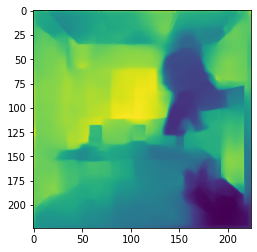

In [ ]:
import matplotlib.pyplot as plt
for img in outputs:
  
  plt.imshow(img[:,:,0])

In [ ]:
%tb

SystemExit: ignored

****

In [ ]:
# # from test import depth_images
# from PIL import Image
# import numpy as np
# path = "/content/DenseDepth/samples"
# def convimage_to_array(imagepath="/content/DenseDepth/samples"):
#   img_array = []
#   for i in os.listdir(imagepath):
#     img = Image.open(os.path.join(path,i))
    
#     if i==0:
#       image = np.expand_dims(np.array(img, dtype=float)/255, axis=0)
#     else:
#       image = np.expand_dims(np.array(img, dtype=float)/255, axis=0)
#       img_array.append(image)

  
#   return img_array

# # 
# import matplotlib.pyplot as plt
# images = convimage_to_array(path)
# save_path = "/content/drive/My Drive/Videos"
# a=depth_images(images, 6)
# for i in a:
#   plt.imshow(i[:,:,0])



In [ ]:
# import os
# import matplotlib.pyplot as plt
# import PIL
# from PIL import Image
# from numpy import asarray
# %matplotlib inline

# samplefile_path = "/content/DenseDepth/samples"
# files = [i for i in os.listdir(samplefile_path)]
# print(files)

# img_array = []
# for f in files:
#   if f.endswith(".jpeg"):
#     img = Image.open(os.path.join(samplefile_path,f))
#   else:
#     continue
#   img_array.append(asarray(img))
#   print("type:",type(img_aray))
#   print("shape:",img_aray.shape)

#   # conv it into depth image
# dp = depth_images(img_aray, 6)
# for i in dp:
#   plt.imshow(i[:,:,0])


**Depth Mask**

In [ ]:
# from PIL import Image
# from numpy import asarray

# def convimage_to_depthmask(img_list,path,batch_size=0):
#   img_array = []
#   for i in img_list:
#     img = Image.open(os.path.join(path,i))
#     if not i.endswith(".jpeg"):
#       continue
    
#     if i==0:
#       image = np.expand_dims(np.array(img, dtype=float)/255, axis=0)
#     else:
#       image = np.expand_dims(np.array(img, dtype=float)/255, axis=0)
#       img_array.append(image)

#   for i in range(1, len(img_list)+1):
#       print(i)
#       dpmap = np.empty([0,224,224,1], dtype=np.float)
#       inputs = load_images(img_array)
#       print(inputs.shape)
#       dpmap[i*batch_size:(i+1)*batch_size,...] = predict_(model, inputs)
#   return dpmap
  


# convimage_to_depthmask(os.listdir("/content/DenseDepth/fg_bg"),"/content/DenseDepth/fg_bg")

In [ ]:
# from matplotlib import pyplot as plt
# from skimage import io

# plt.figure(figsize=(150,100))
# plt.imshow( io.imread("/content/DenseDepth/test.png") )

In [ ]:
# # Depth maps
# !python /content/DenseDepth/test.py --model /content/DenseDepth/nyu.h5 --imagefiles "/content/DenseDepth/samples/*.jpeg"